# Challenge Data - Football: qui va gagner ?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
base_path = './data'
path_data = './train_team.csv'
path_target = f'{base_path}/Y_train_1rknArQ.csv'

In [3]:
data = pd.read_csv(path_data, sep=',')
target = pd.read_csv(path_target, sep=',')

## Séparation train/test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['ID', 'HOME_LEAGUE', 'HOME_TEAM_NAME', 'AWAY_LEAGUE', 'AWAY_TEAM_NAME']), 
    target, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
    )

In [5]:
print(f"Nombre de données d'entrainement: {X_train.shape[0]}")
print(f"Nombre de données de test: {X_test.shape[0]}")

Nombre de données d'entrainement: 9842
Nombre de données de test: 2461


## Imputation et standardisation des données

In [6]:
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)

## K-Nearest Neighbors

Nous allons faire un label encoding pour la variable cible

In [7]:
y_train_encoded = y_train.drop(columns='ID').apply(lambda x: np.where(x.to_numpy() == 1)[0][0], axis=1)
y_test_encoded = y_test.drop(columns='ID').apply(lambda x: np.where(x.to_numpy() == 1)[0][0], axis=1)

Nous allons performer un grid search sur differents nombres de voisins et différents métriques

In [8]:
n_neighbors = np.arange(5, 150, 5)
param_grid = {
    'n_neighbors': n_neighbors,
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

knn = KNeighborsClassifier(n_jobs=-1)

grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=10).fit(X_train_scaled, y_train_encoded)

Fitting 5 folds for each of 87 candidates, totalling 435 fits


[CV 3/5; 2/87] START metric=euclidean, n_neighbors=10...........................[CV 2/5; 2/87] START metric=euclidean, n_neighbors=10...........................
[CV 5/5; 1/87] START metric=euclidean, n_neighbors=5............................
[CV 1/5; 1/87] START metric=euclidean, n_neighbors=5............................
[CV 1/5; 2/87] START metric=euclidean, n_neighbors=10...........................
[CV 3/5; 1/87] START metric=euclidean, n_neighbors=5............................
[CV 2/5; 1/87] START metric=euclidean, n_neighbors=5............................

[CV 4/5; 1/87] START metric=euclidean, n_neighbors=5............................
[CV 2/5; 1/87] END metric=euclidean, n_neighbors=5;, score=0.432 total time=   1.0s[CV 4/5; 1/87] END metric=euclidean, n_neighbors=5;, score=0.414 total time=   1.0s

[CV 3/5; 1/87] END metric=euclidean, n_neighbors=5;, score=0.416 total time=   1.0s
[CV 5/5; 1/87] END metric=euclidean, n_neighbors=5;, score=0.417 total time=   1.0s[CV 1/5; 2/87] EN

/home/leonardo/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [9]:
best_params_knn = grid_search.best_params_
X_test_scaled = scaler.transform(imputer.transform(X_test))
score_knn = grid_search.score(X_test_scaled, y_test_encoded)

print(f'{best_params_knn=}')
print(f'{score_knn=}')

best_params_knn={'metric': 'euclidean', 'n_neighbors': 120}
score_knn=0.48720032507110933


Text(0.5, 1.0, 'KNN - metric: chebyshev')

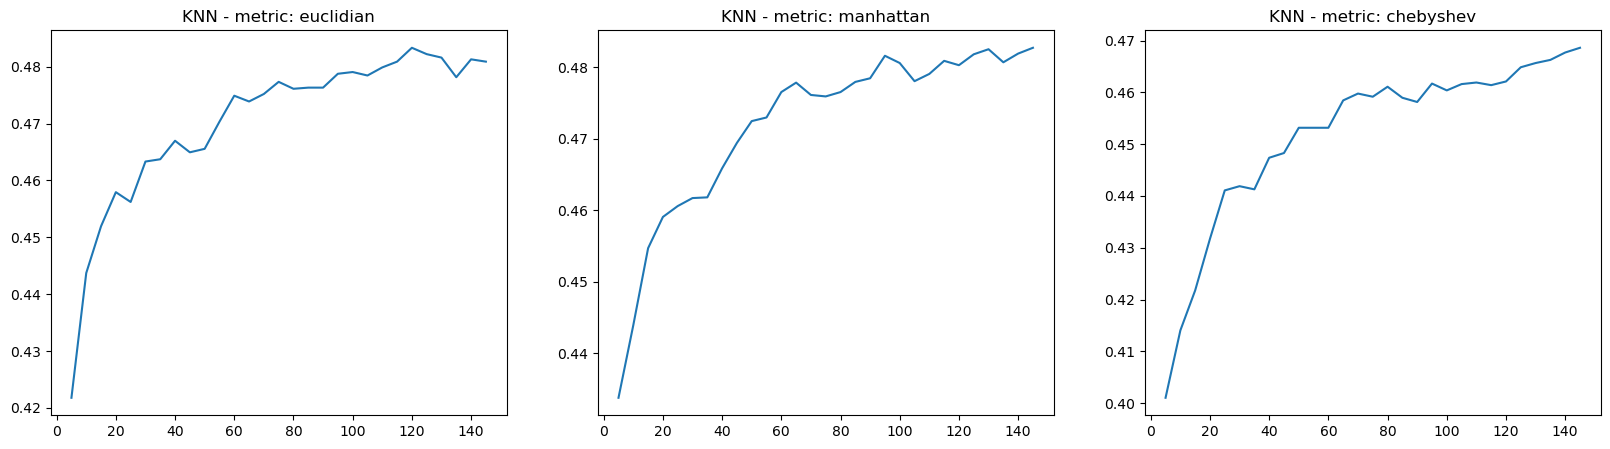

In [34]:
euclidian = grid_search.cv_results_['mean_test_score'][:len(n_neighbors)]
manhattan = grid_search.cv_results_['mean_test_score'][len(n_neighbors):2*len(n_neighbors)]
chebyshev = grid_search.cv_results_['mean_test_score'][2*len(n_neighbors):]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.plot(n_neighbors, euclidian)
ax1.set_title('KNN - metric: euclidian')
ax2.plot(n_neighbors, manhattan)
ax2.set_title('KNN - metric: manhattan')
ax3.plot(n_neighbors, chebyshev)
ax3.set_title('KNN - metric: chebyshev')

Nous pouvons remarquer avec les figures ci-dessus l'évolution du score par rapport au nombre de voisins pour chaque métrique utilisé. Nous observons l'effet du overfitting quand nous avons un nombre des voisins faibles. C'est possible de remarquer aussi une stabilisation de l'évolution du score après 100 voisins.

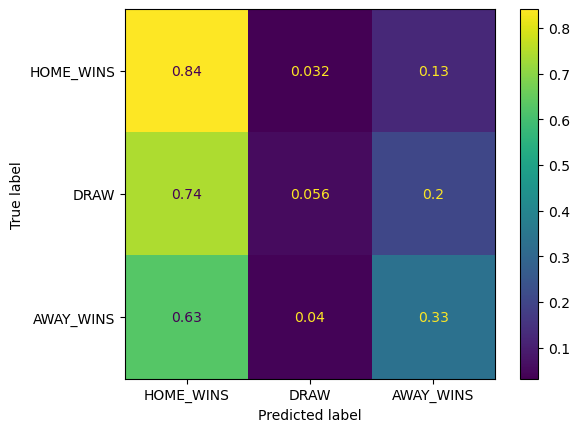

In [36]:
y_pred = grid_search.predict(X_test_scaled)
cm = confusion_matrix(y_test_encoded, y_pred, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=['HOME_WINS', 'DRAW', 'AWAY_WINS']).plot()

## Regression Logistique

In [ ]:
# Transform the linear exit into probabilities
def Trans_prob(z): 
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Average Loss between the actual labels and the predicted probabilities 
def avg_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + 1e-15)) / n_samples
    return loss

# Gradient Descent
def gradient_descent(X, y, lr=0.01, n_iter=1000):
    n_samples, n_features = X.shape
    n_classes = y.shape[1]
    
    weights = np.zeros((n_features, n_classes))
    bias = np.zeros((1, n_classes))
    
    for i in range(n_iter):
        linear_model = np.dot(X, weights) + bias
        y_pred = Trans_prob(linear_model)
        
        loss = avg_loss(y, y_pred)
        
        dw = np.dot(X.T, (y_pred - y)) / n_samples
        db = np.sum(y_pred - y, axis=0, keepdims=True) / n_samples
        
        weights -= lr * dw
        bias -= lr * db
        
        if i % 100 == 0:
            print(f"Iteration {i}: Loss = {loss}")
    
    return weights, bias

# Find the class index with max probability 
def predict(X, weights, bias):
    linear_model = np.dot(X, weights) + bias
    probabilities = Trans_prob(linear_model)
    return np.argmax(probabilities, axis=1)

In [11]:
y_train_onehot = pd.get_dummies(y_train).values
y_test_onehot = pd.get_dummies(y_test).values

In [12]:
weights, bias = gradient_descent(X_train_scaled, y_train_onehot, lr=0.1, n_iter=1000)


Iteration 0: Loss = 8573.606495268612
Iteration 100: Loss = 34.53877639490383
Iteration 200: Loss = 34.53877639490383
Iteration 300: Loss = 34.53877639490383
Iteration 400: Loss = 34.53877639490383
Iteration 500: Loss = 34.53877639490383
Iteration 600: Loss = 34.53877639490383
Iteration 700: Loss = 34.53877639490383
Iteration 800: Loss = 34.53877639490383
Iteration 900: Loss = 34.53877639490383


In [13]:
y_pred = predict(X_test_scaled, weights, bias)
y_test_labels = np.argmax(y_test_onehot, axis=1)

In [15]:
score_reglog = grid_search.score(X_test_scaled, y_test_encoded)
score_reglog

0.48720032507110933